In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import cv2

from colorama import Fore, Back, Style
from tensorflow import keras
from tensorflow.keras import layers
import random
import torch
from torchvision import transforms
from PIL import Image
convert_tensor = transforms.ToTensor()
import os
import torch.nn as nn
import torchvision

2024-04-28 17:05:26.987327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 17:05:26.987483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 17:05:27.162058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Description of problem and data

In this weeks assignment we are  participating in the Kaggle Monet Painting Dataset Competition. The objective of the project is to use GANs to replicate Claude Monet's artistic style in real  images. The goal is to produce 7,000 to 10,000 Monet-style images for evaluation. Generative Deep Learning models are a  deep learning technique focused on creating new data samples that resemble a given dataset. They are used in fileds including but not limited to image generation and text generation. The goal of the model is to learn the underlying distribution of the training data and then generate new data from the learned distribution.One powerful category within generative models is Generative Adversarial Networks (GANs), which consist of a generator and a discriminator trained adversarially. The generator generates realistic data  and the discriminator distinguishes between real and generated samples leading to the improvement of the generator's ability to produce more realistic data.



In [2]:
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
    

# Data Preprocessing and EDA

The below code is loading in our data sets. We can also see from this code that the images are of size 256 x 256. We also see that there are 300 monet images and 7038 real photos for us to use. Due to this datset being created for this project we will not need to do other additional preprocessing other than verifying that the monet images are indeed monet paintings and that the real photos are real photos.

In [3]:
monet_jpg_directory = '../input/gan-getting-started/monet_jpg/'
photo_jpg_directory = '../input/gan-getting-started/photo_jpg/'

def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)

monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)

In [4]:
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)
        
getShape(monet_images_path)
print(getShape(photo_images_path))
print(len(monet_images_path))
print(len(photo_images_path))

Same image shape (256, 256, 3)
300
7038


Below is a helper function that will allow us to seem some of the data contained in each of the data sets 

In [5]:
def display_multiple_img(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(8,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

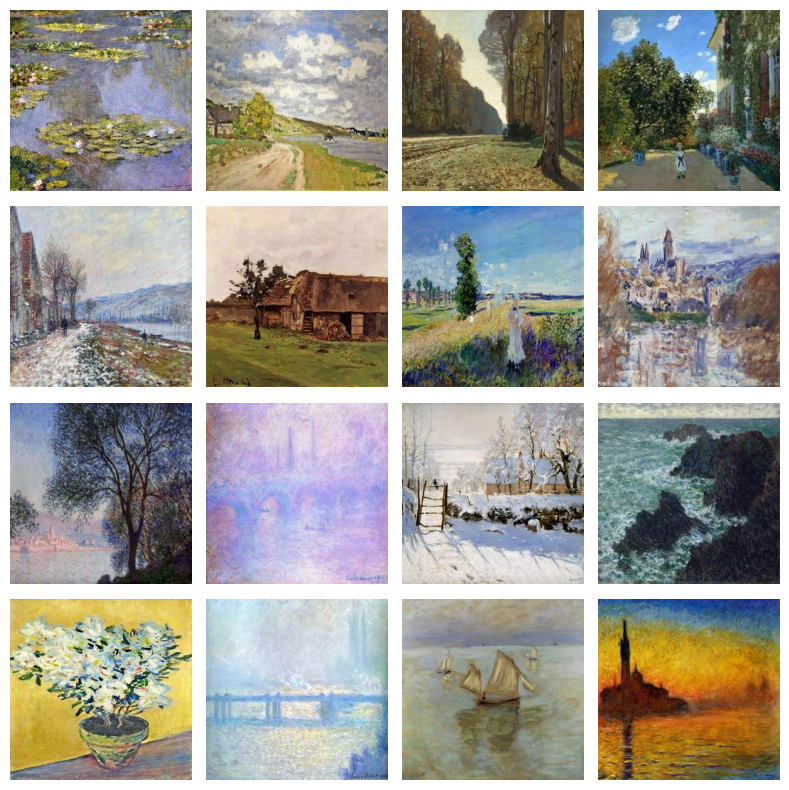

In [6]:
display_multiple_img(monet_images_path, 4, 4)

After analyzing these photos we can start to get an idea of what the Monet Style exactly is but first we also need to see the real photos for a point of comparison.

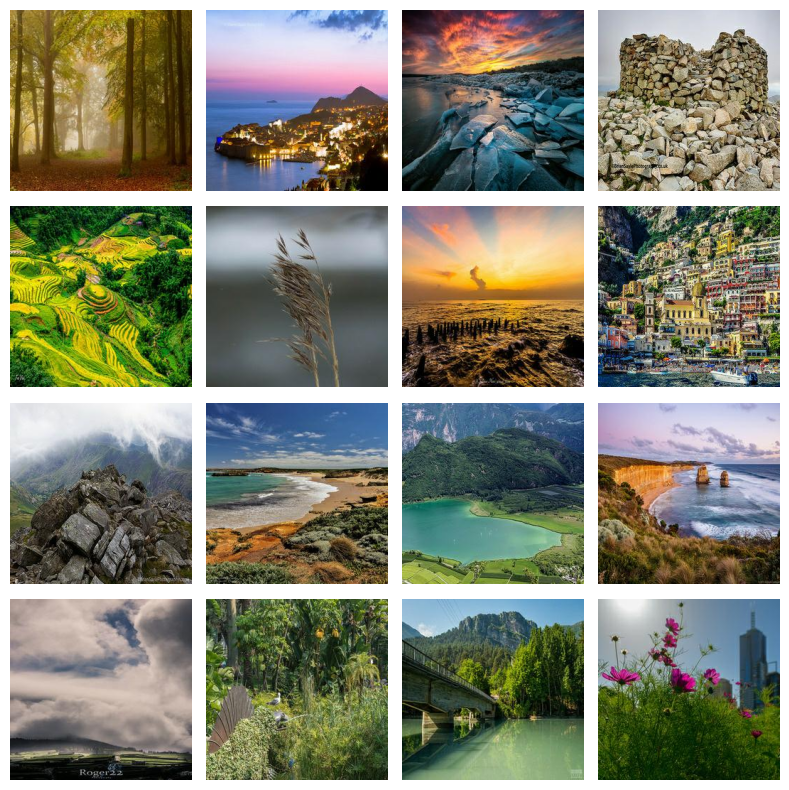

In [7]:
display_multiple_img(photo_images_path, 4, 4)

Ater analyzing the above photos and comparing them with the Monet paintings we can visually start to get an idea on the differences between the two. While it may be easy to tell the differnece by eye for us, We need to attempt to see if there are any patterns in the pixel color readings and distributions for our GAN to be able to operate on the data.

Below is code that will allow us to graphically see the differneces in terms of pixel color distrtibution. 

In [8]:
def styling():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        plt.xticks([])
        plt.yticks([])
def hist(image_path):
    plt.figure(figsize=(16, 3))
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    styling()
    
    custom_colors = ["#ef233c", "#76da71", "#2667ff","#aea3b0"]
    labels = ['Red Channel', 'Green Channel', 'Blue Channel','Total']
    
    for i in range(1,4):
        plt.subplot(1, 5, i+1)
        plt.hist(img[:, :, i-1].reshape(-1),bins=64,color=custom_colors[i-1],alpha = 0.6)
        plt.xlabel(labels[i-1],fontsize=10)
        styling()
        
    plt.subplot(1, 5, 5)
    plt.hist(img.reshape(-1),bins=128,color=custom_colors[3],alpha = 0.6)
    plt.xlabel(labels[3],fontsize=10)
    styling()
    plt.show()

def display_hist(images_paths):
        for ind,image_path in enumerate(images_paths):
            if (ind<6):
                hist(image_path)

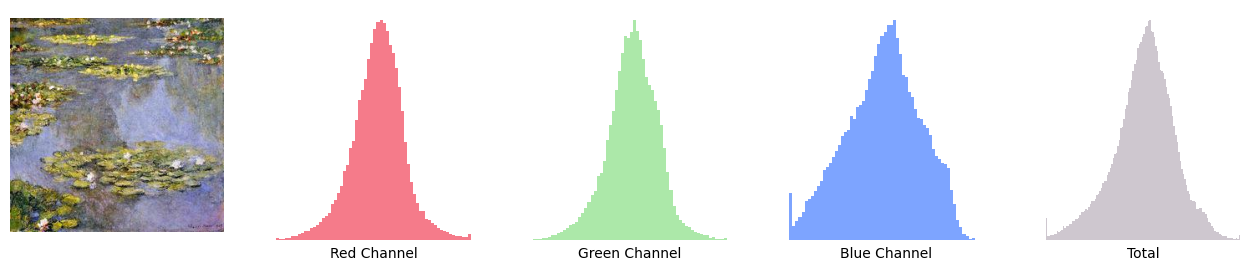

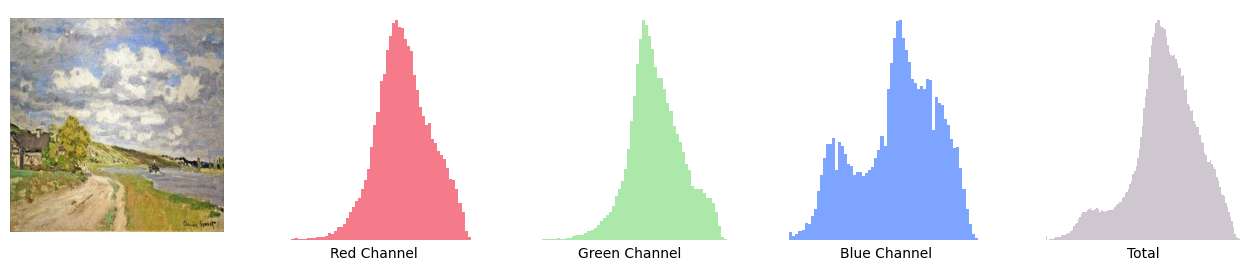

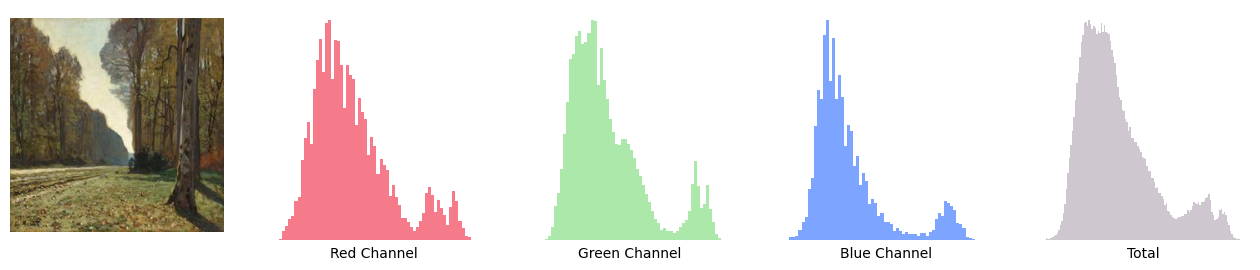

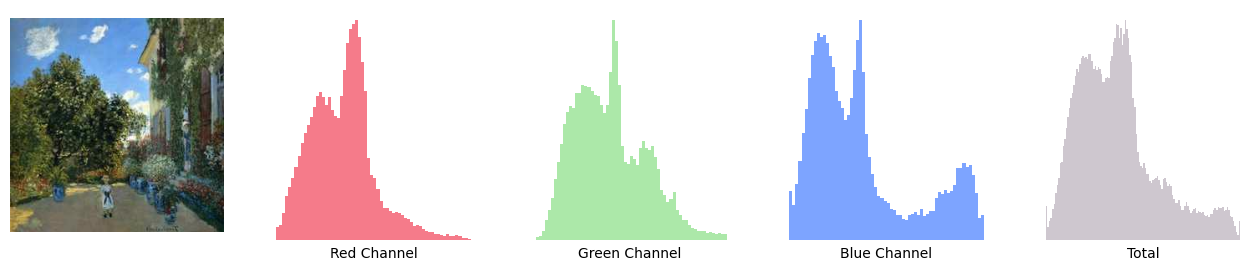

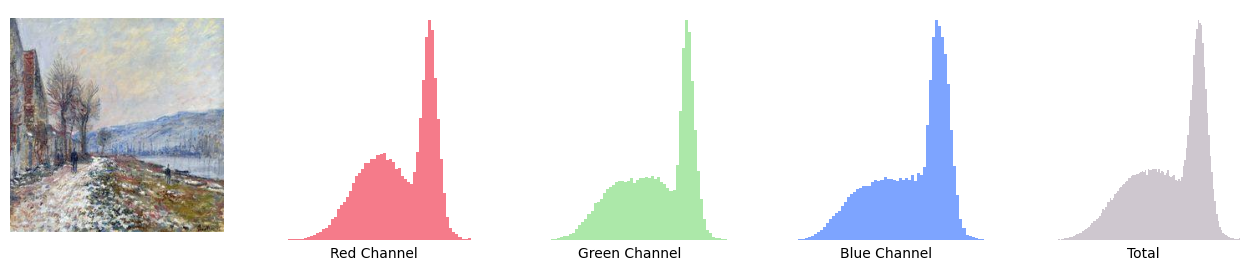

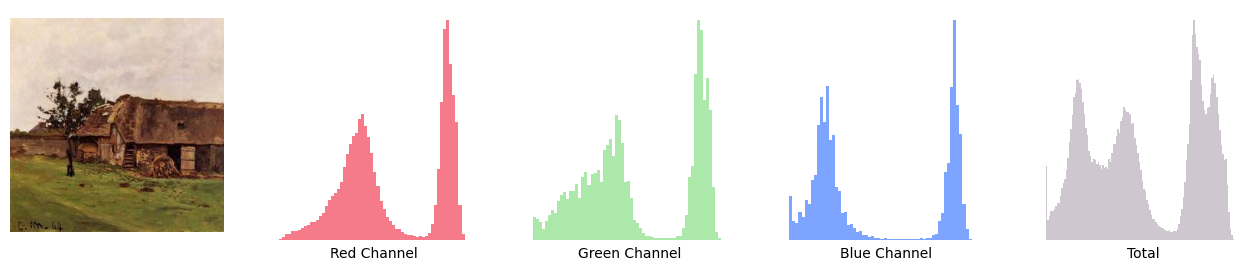

In [9]:
display_hist(monet_images_path)

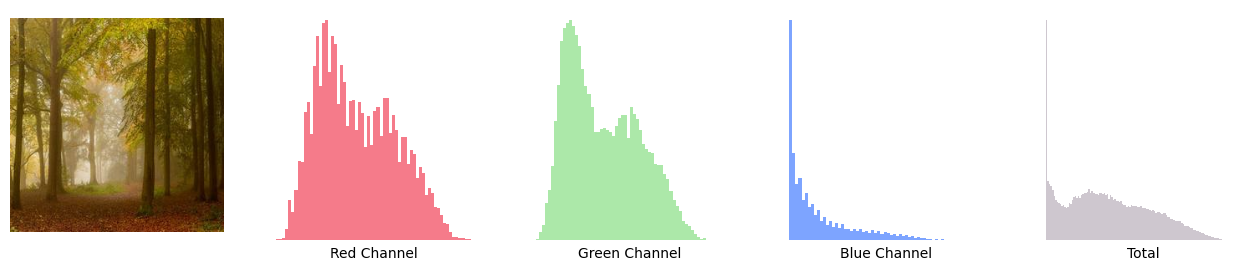

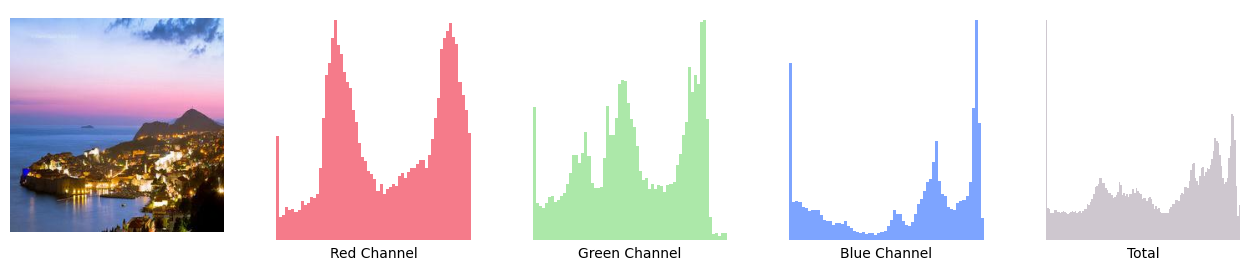

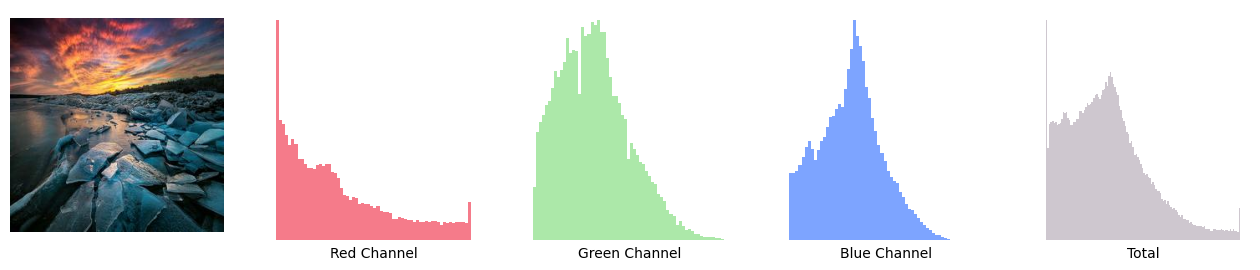

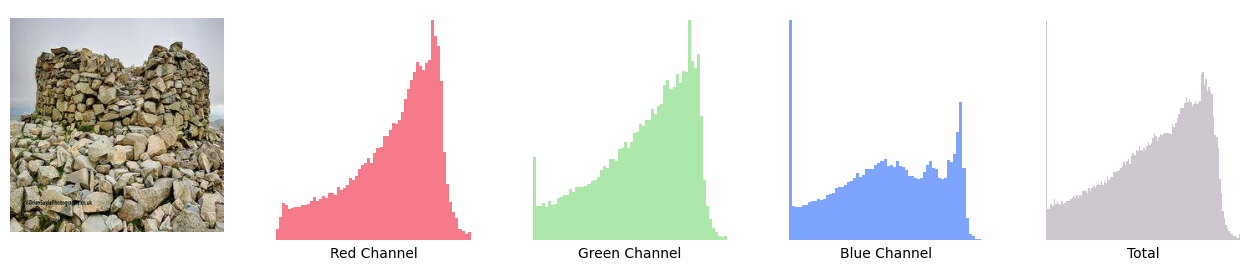

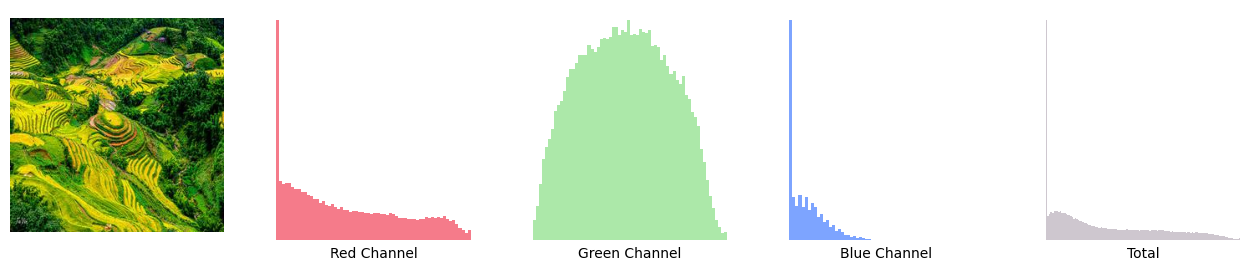

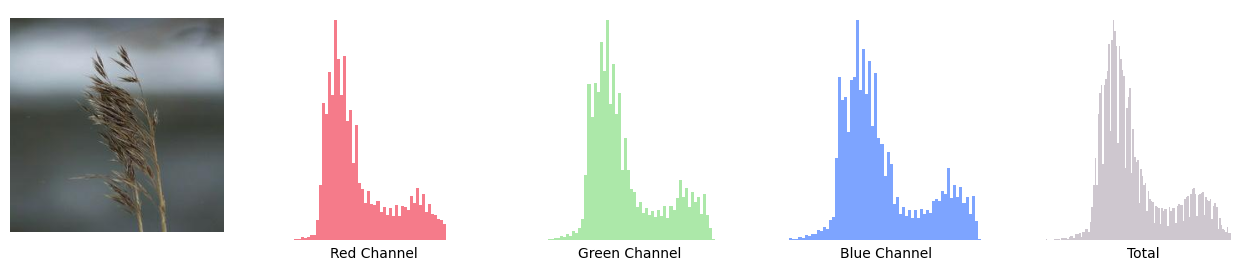

In [10]:
display_hist(photo_images_path)

After comapring and analyzing the distribution of pixel color values and total values, We can start to see that the monet images tend to have much higher levels of distinct values but also tend to have more distribution among themselves as well. 

# Model construction and Architecture 

GAN Model:

A GAN model consists of two neural networks: a Generator and a Discriminator.

Generator: It takes random noise as input and generates fake data samples. The goal of the generator is to produce data that is indistinguishable from real data.

Discriminator: It takes both real data samples and fake data samples generated by the generator as input and distinguishes between them. It aims to correctly classify real data as real and fake data as fake.

Architecture of the Model:

Generator Architecture: Typically consists of one or more fully connected dense layers followed by activation functions  LeakyReLU and a final layer with an appropriate activation function .

Discriminator Architecture: Also composed of fully connected layers with activation functions like LeakyReLU, culminating in a final output layer with a sigmoid activation function, which outputs a probability indicating the likelihood of the input being real or fake(for loop).

GAN Architecture: The GAN model combines the generator and discriminator. It connects the generator's output to the discriminator's input, forming a pipeline. During training, the generator is trained to maximize the discriminator's error on fake samples, while the discriminator is trained to correctly classify real and fake samples.

The learning rate has been set to 0.0001

The number of epochs has been set to 5

The batch size has been set to 4

In [11]:
images = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        if filename.find(".jpg") != -1:
            if random.random() > 0.5:
                images.append(convert_tensor(Image.open(dirname + "/" + filename)))
images = torch.stack(images)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images = images.view(images.shape[0], -1).to(device)

In [12]:
class GAN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.picasso = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(out_size, 1),
            nn.Sigmoid()
        )
    def forward(self, ins):
        return self.picasso(ins)
    def gan_forward(self, ins):
        return self.critic(ins)
    def __call__(self, ins):
        return self.forward(ins)
    
net = GAN(10, 200, 3 * 256 * 256).to(device)
net.gan_forward(net(torch.randn(10).to(device)))

num_epochs = 5
batch_size = 4
train_len = len(images)
num_steps = (train_len//batch_size) * num_epochs
lr = 0.0001
optimG = torch.optim.AdamW(net.picasso.parameters(), lr=lr)
optimD = torch.optim.SGD(net.critic.parameters(), lr=lr)

for step in range(num_steps):
    d_batch_real = images[torch.randint(1, train_len-1, (batch_size//2,))]
    d_batch_gen = net(torch.randn(batch_size//2, 10).to(device))
    d_batch = torch.cat((d_batch_real, d_batch_gen)).to(device)
    d_ys = torch.cat((torch.zeros(batch_size//2, 1), torch.ones(batch_size//2, 1))).to(device)
    d_out = net.gan_forward(d_batch)
    
    d_loss = nn.functional.binary_cross_entropy(d_out, d_ys)
    optimD.zero_grad()
    d_loss.backward()
    optimD.step()
    
    
    g_batch = torch.randn(batch_size, 10).to(device)
    g_out = net(g_batch)
    
    g_loss = net.gan_forward(g_out).sum() / len(g_out)
    optimG.zero_grad()
    g_loss.backward()
    optimG.step()
    
    if step % 100 == 0:
        print("Step", str(step) + ", loss D:", str(d_loss.item()) + ", loss G:", g_loss.item())

Step 0, loss D: 0.6908974647521973, loss G: 0.5689743757247925
Step 100, loss D: 2.382537841796875, loss G: 0.5884467363357544
Step 200, loss D: 0.345893919467926, loss G: 0.20849409699440002
Step 300, loss D: 28.4354305267334, loss G: 0.8666964173316956
Step 400, loss D: 5.844624042510986, loss G: 0.5952140688896179
Step 500, loss D: 1.6238715648651123, loss G: 0.375993937253952
Step 600, loss D: 0.9519037008285522, loss G: 0.6276330947875977
Step 700, loss D: 0.7132089138031006, loss G: 0.4927228093147278
Step 800, loss D: 0.9824817180633545, loss G: 0.5779717564582825
Step 900, loss D: 0.8549433350563049, loss G: 0.6133232116699219
Step 1000, loss D: 0.5444614887237549, loss G: 0.7401549816131592
Step 1100, loss D: 0.5824393630027771, loss G: 0.6703192591667175
Step 1200, loss D: 0.5844290852546692, loss G: 0.5078898668289185
Step 1300, loss D: 0.4774007797241211, loss G: 0.5523875951766968
Step 1400, loss D: 0.5038963556289673, loss G: 0.609717607498169
Step 1500, loss D: 0.5412905

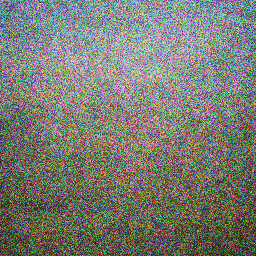

In [13]:
with torch.no_grad():
    ins = torch.randn(10).to(device)
    net_out = net(ins).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(net_out)
    display(image)

# Discusion: Analysis and Conclusion

In conclusion the effectiveness of my CycleGAN network model in processing the provided images to look like Monet with the hyperparameters slected was far from optimal. The workflow involved in working with neural networks is very time-consuming in nature because of training models that are having to process image data this scaled the running time quite a bit. The limited GPU resources presented a challenge, particularly in handling image data processing part of the workflow. Although the overall process worked well. Given sufficient computing power, Improvements such as extending the training epochs for more precise results and implementing automated hyperparameter tuning could be implemneted to increase the performance of my model in the future 

In [14]:
! mkdir ../images

for i in range(8000):
    seed = torch.randn(10).to(device)
    out = net(seed).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(out)
    image.save("../images/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


'/kaggle/working/images.zip'